In [10]:
import numpy as np
import matplotlib.pyplot as plt
import edmcmc as edm
import corner
import time

In [2]:
x = np.linspace(0, 10, 30)# generate an evenly sampled X axis (not strictly necessary for this problem). 
slope_true = 1.5
intercept_true = 4
uncertainty_true = 1 # These parameters are the "truth" that our MCMC will try to recover. 

In [3]:
y = slope_true * x + intercept_true #Calculate the y values based on the linear model
y = y + np.random.normal(0, uncertainty_true, len(x)) #and add some random noise with
#a Gaussian distribution centered on 0, with a standard deviation of 1. 
err = np.ones_like(y) * uncertainty_true

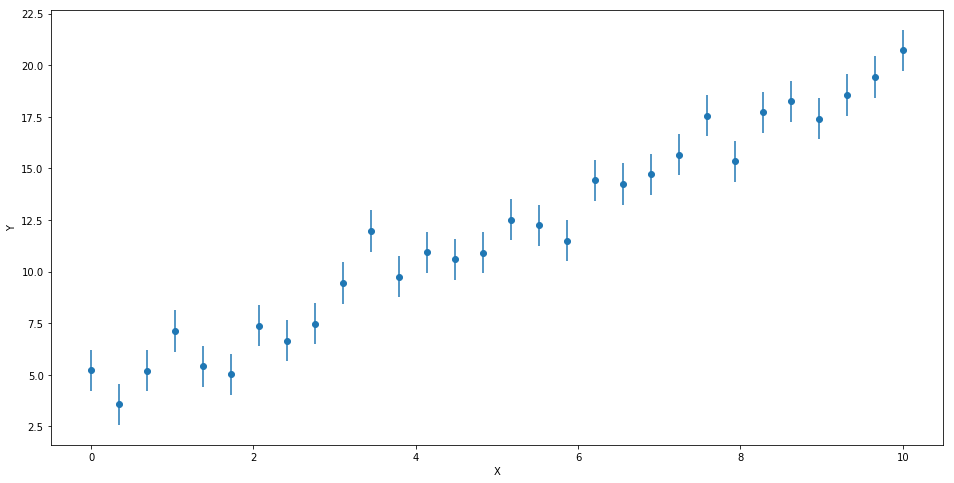

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(x, y, yerr = np.ones_like(y) * uncertainty_true, fmt = 'o')
ax.set_ylabel('Y');
ax.set_xlabel('X');


In [5]:
def loglikelihood(p, x, y, e): #here p is an array of the parameters: let's define p[0] = slope, and p[1] = intercept 
    slope = p[0]
    intercept = p[1]
    model = slope * x + intercept
    chisq = np.sum((y - model)**2 / e**2) 
    loglikelihood = -0.5 * chisq
    return loglikelihood

In [6]:
out = edm.edmcmc(loglikelihood, [0,0], [.1,.1],
             args=(x,y,err), nwalkers=200, nlink = 1000, nburnin=500)
print(np.median(out.flatchains[:,0]), '+/-', np.std(out.flatchains[:,0]), ';    ', np.median(out.flatchains[:,1]), '+/-', np.std(out.flatchains[:,1]))


0 days, 00:00:00.0 remains. Link 1000 of 1000. Acceptance Rate= 0.35
1.6045879338043278 +/- 0.06122343378669023 ;     3.8807526942461106 +/- 0.35626412256551404


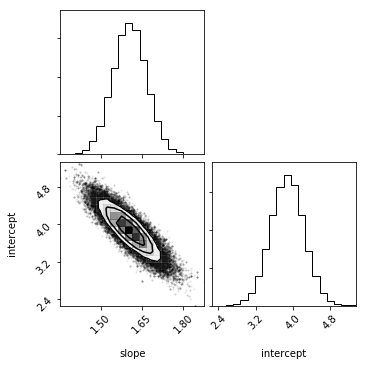

In [7]:
corner.corner(out.flatchains,labels=['slope', 'intercept'])
plt.show()

In [12]:
def expensiveloglikelihood(p, x, y, e): #here p is an array of the parameters: let's define p[0] = slope, and p[1] = intercept 
    
    j = np.zeros(20000) + 2#this doesn't do anything but make the likelihood function more expensive 
    j = j**j #to test parallelization
    
    slope = p[0]
    intercept = p[1]
    model = slope * x + intercept
    chisq = np.sum((y - model)**2 / e**2) 
    loglikelihood = -0.5 * chisq
    return loglikelihood

In [13]:
starttime = time.time()
out = edm.edmcmc(expensiveloglikelihood, [0,0], [.1,.1],
             args=(x,y,err), nwalkers=200, nlink = 1000, nburnin=500)
print(np.median(out.flatchains[:,0]), '+/-', np.std(out.flatchains[:,0]), ';    ',
      np.median(out.flatchains[:,1]), '+/-', np.std(out.flatchains[:,1]))
print('One thread: ', time.time()-starttime, ' seconds')

starttime = time.time()
out = edm.edmcmc(expensiveloglikelihood, [0,0], [.1,.1],
             args=(x,y,err), nwalkers=200, nlink = 1000, nburnin=500, ncores=4)
print(np.median(out.flatchains[:,0]), '+/-', np.std(out.flatchains[:,0]), ';    ',
      np.median(out.flatchains[:,1]), '+/-', np.std(out.flatchains[:,1]))
print('Four thread: ', time.time()-starttime, ' seconds')




0 days, 00:00:00.0 remains. Link 1000 of 1000. Acceptance Rate= 0.35
1.6035340704709997 +/- 0.06100481674265942 ;     3.8819686593167813 +/- 0.35407543351860465
One thread:  61.19562005996704  seconds
0 days, 00:00:00.0 remains. Link 1000 of 1000. Acceptance Rate= 0.35
1.602943566083409 +/- 0.061160289768387686 ;     3.8814092376921043 +/- 0.35408934553237165
Four thread:  34.13109993934631  seconds
